In [1]:
import os.path as osp
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from sklearn.cluster import DBSCAN
from torch_geometric.data import Data
import torch_geometric.transforms as ttr

from astropy.io import fits
from astropy.table import Table
from astropy import table as astropy_table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

from mptd.reader import get_raw_data
from mptd.simple_message import SimpleMessage
from mptd.plotter import plot_data, plot_clusters, plot_fits_data


In [2]:
DEVICE="cpu"#"cuda:0"

In [3]:
from typing import Any

class MPTDData(Data):
    """
    Represents the data for Message-Passing Transient Detection (MPTD).

    Parameters
    ----------
    x : None
        Feature data (not used in this context).
    edge_index : None
        Graph edge indices (not used in this context).
    edge_attr : None
        Graph edge attributes (not used in this context).
    y : None
        Target labels (not used in this context).
    pos : torch.Tensor
        Tensor representing the node positions (coordinates).
    **kwargs
        Additional keyword arguments.

    Returns
    -------
    MPTDData
        A new instance of MPTDData with the given node positions.

    Raises
    ------
    ValueError
        If the data object has no valid tensor for indexing.
    """

    def __init__(self, x=None, edge_index=None, edge_attr=None, y=None, pos=None, **kwargs):
        assert x is None
        super().__init__(x, edge_index, edge_attr, y, pos, **kwargs)

    @property
    def x(self):
        """
        Get the node positions (coordinates) stored in 'pos' attribute.

        Returns
        -------
        torch.Tensor
            Node positions (coordinates).
        """
        return self.pos
    
    def append(self, other):
        """
        Append the data from another MPTDData object to the current instance.

        Parameters
        ----------
        other : MPTDData
            Another MPTDData object to append.

        Returns
        -------
        MPTDData
            A new instance of MPTDData with the combined data.
        """
        new_edge_index = torch.hstack([self.edge_index, other.edge_index]) \
                         if other.edge_index is not None and self.edge_index is not None else None
        new_edge_attr = torch.hstack([self.edge_attr, other.edge_attr]) \
                        if other.edge_attr is not None and self.edge_attr is not None else None
        
        return MPTDData(x=torch.vstack([self.x, other.x]), 
                        y=torch.hstack([self.y, other.y]), 
                        pos=torch.vstack([self.y, other.y]), 
                        edge_index=new_edge_index,
                        edge_attr=new_edge_attr
                        )    
 
    def getsplice(self, index):
        """
        Get a new MPTDData object by selecting specific nodes based on the given index.

        Parameters
        ----------
        index : torch.Tensor
            The index tensor used for selecting nodes.

        Returns
        -------
        MPTDData
            A new instance of MPTDData with selected nodes.
        """
        y = self.y[index] if self.y is not None else None
        pos = self.pos[index] if self.pos is not None else None

        return MPTDData(y=y, pos=pos)
    
    def __len__(self):
        """
        Get the number of nodes in the data object.

        Returns
        -------
        int
            Number of nodes in the data object.

        Raises
        ------
        ValueError
            If the data object has no valid tensor for indexing.
        """
        if self.y is not None:
            return self.y.size(0)
        else:
            raise ValueError("The data object has no valid tensor for indexing.")   


In [4]:

class MPTDDataset:
    """
    Represents a dataset for Message-Passing Transient Detection (MPTD).

    Parameters
    ----------
    filenames : str or List[str]
        File name(s) of the dataset.
    keys : List[str]
        List of keys used to extract data from the dataset files.
    filters : dict
        A dictionary containing filters for the dataset.
    withsim : bool, optional
        Whether to include simulated data, by default True.

    Returns
    -------
    None
    """

    def __init__(self, filenames, keys, filters:dict, withsim=True) -> None:
        if type(filenames) is str:
            filenames = [filenames]
        filename = filenames[0]
        ismos = filename.endswith("MIEVLF0000.FTZ") or filename.endswith("MIEVLI0000.FTZ")
        lastcolname = "PHA" if ismos else "TIME_RAW"
        keys_plus = keys + [lastcolname]
        raw_data = get_raw_data(filename, keys_plus, filters)
        # with fits.open(filename) as hdul:
        #     header = hdul[0].header
        # frame, date = header["RADECSYS"].lower(), Time(header["DATE-OBS"], format='isot')
        # coords = SkyCoord(*(raw_data.to_pandas()[["X","Y"]].to_numpy().T * 0.05), unit=u.arcsec, frame=frame, obstime=date).transform_to("icrs")
        # raw_data["X"] = coords.to_table()["ra"]
        # raw_data["Y"] = coords.to_table()["dec"]
        for filename in filenames[1:]:
            ismos = filename.endswith("MIEVLF0000.FTZ") or filename.endswith("MIEVLI0000.FTZ")
            lastcolname = "PHA" if ismos else "TIME_RAW"
            keys_plus = keys + [lastcolname]
            raw_data = astropy_table.vstack([raw_data, get_raw_data(filename, keys_plus, filters)])
            # with fits.open(filename) as hdul:
            #     header = hdul[0].header
            # frame, date = header["RADECSYS"].lower(), Time(header["DATE-OBS"], format='isot')
            # coords = SkyCoord(*(raw_data.to_pandas()[["X","Y"]].to_numpy().T * 0.05), unit=u.arcsec, frame=frame, obstime=date).transform_to("icrs")
            # raw_data["X"] = coords.to_table()["ra"]
            # raw_data["Y"] = coords.to_table()["dec"]

        issimulated = torch.from_numpy(np.array(raw_data["ISSIMULATED"])).bool()
        self.groups = torch.from_numpy(np.array(raw_data[lastcolname]))
        self.groups[~issimulated] = -1

        if withsim:
            self.data = MPTDData(pos=torch.from_numpy(np.array([raw_data[key] for key in keys]).T).float(),
                                 y=issimulated.long()).to(DEVICE)
        else:
            self.data = MPTDData(pos=torch.from_numpy(np.array([raw_data[key] for key in keys]).T[~issimulated]).float(),
                                 y=issimulated[~issimulated].long()).to(DEVICE)
            
        self.keys = keys

    def get_group(self, group):
        """
        Get nodes belonging to a specific group.

        Parameters
        ----------
        group : int
            Group index.

        Returns
        -------
        torch.Tensor
            Node positions (coordinates) belonging to the specified group.
        """
        indices = self.groups == group
        return self.data.pos[indices]
    
    def list_groups(self):
        """
        Get a tensor containing unique group indices.

        Returns
        -------
        torch.Tensor
            A tensor containing unique group indices.
        """
        return torch.unique(self.groups)


In [5]:

class MPTDElaborator:
    """
    Performs data elaboration for Message-Passing Transient Detection (MPTD).

    Parameters
    ----------
    dataset : MPTDDataset
        The dataset used for elaboration.
    transformer : Any
        The transformer used to transform the dataset data.
    keys : List[str]
        List of keys used for data transformation.
    model : Any
        The model used for data elaboration.

    Returns
    -------
    None
    """

    def __init__(self, dataset:MPTDDataset, transformer, keys, model) -> None:
        self.dataset = dataset
        self.net_data = transformer(dataset.data)
        self.keys = keys
        self.model = model
        self.iterations = 0
        self.elaborated_data = torch.ones_like(self.net_data.x[:, 0].unsqueeze(-1))  # Initialize elaborated data

    def sizes(self):
        """
        Get the sizes of the elaborated data.

        Returns
        -------
        torch.Tensor
            Sizes of the elaborated data.
        """
        return self.elaborated_data.squeeze()
    
    def distances(self):
        """
        Compute the distances between nodes in the elaborated data.

        Returns
        -------
        torch.Tensor
            Distances between nodes in the elaborated data.
        """
        return torch.norm(self.net_data.pos[self.net_data.edge_index[0]] - self.net_data.pos[self.net_data.edge_index[1]], dim=1)
    
    def forward(self, iterations=1):
        """
        Perform the forward pass on the model for a specified number of iterations.

        Parameters
        ----------
        iterations : int, optional
            The number of iterations to run the forward pass, by default 1.

        Returns
        -------
        torch.Tensor
            Sizes of the elaborated data after the forward pass.
        """
        for _ in range(iterations):
            self.elaborated_data += self.model.forward(self.elaborated_data, self.net_data.edge_index)
            self.iterations += 1
            self.elaborated_data /= self.elaborated_data.max()
        return self.sizes()
    
    def forward_plot(self, iterations, plot_every=1, plot_after=0, max_threshold=0.5):
        """
        Perform forward passes on the model and create plot data.

        Parameters
        ----------
        iterations : int
            Total number of iterations to run the forward pass.
        plot_every : int, optional
            Number of iterations to plot data after, by default 1.
        plot_after : int, optional
            Number of iterations to run before starting the plot, by default 0.
        max_threshold : float, optional
            Maximum threshold value, by default 0.5.

        Returns
        -------
        torch.Tensor
            Sizes of the elaborated data after the forward pass.
        """
        sizes = self.forward(iterations=plot_after)
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        while self.iterations < iterations:
            plot_data(self.net_data.pos[mask].cpu(), sizes[mask].cpu(), issimulated=self.net_data.y[mask].cpu().bool(), 
                      keys=self.keys, title=f"iteration {self.iterations}", 
                      outfile=osp.join("video_frames", f"frame_{self.iterations:02}.png"))
            sizes = self.forward(iterations=min(iterations - self.iterations, plot_every))
            threshold = min(sizes.mean().item(), max_threshold)
            mask = sizes >= threshold
        
        plot_data(self.net_data.pos[mask].cpu(), sizes[mask].cpu(), issimulated=self.net_data.y[mask].cpu().bool(), 
                  keys=self.keys, title=f"iteration {self.iterations}", 
                  outfile=osp.join("video_frames", f"frame_{self.iterations:02}.png"))

        return sizes

    def auto_forward(self, rej_threshold, max_threshold):
        """
        Perform an automatic forward pass on the model.

        Parameters
        ----------
        rej_threshold : float
            Threshold for rejection.
        max_threshold : float
            Maximum threshold value.

        Returns
        -------
        torch.Tensor
            Sizes of the elaborated data after the forward pass.
        """
        sizes = self.sizes()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        old_len = mask.sum()
        self.elaborated_data += self.model.forward(self.elaborated_data, self.net_data.edge_index)
        self.iterations += 1
        self.elaborated_data /= self.elaborated_data.max()
        sizes = self.sizes()
        threshold = min(sizes.mean().item(), max_threshold)
        mask = sizes >= threshold
        new_len = mask.sum()
        while old_len - new_len > rej_threshold:
            old_len = new_len
            self.elaborated_data += self.model.forward(self.elaborated_data, self.net_data.edge_index)
            self.iterations += 1
            self.elaborated_data /= self.elaborated_data.max()
            sizes = self.sizes()
            threshold = min(sizes.mean().item(), max_threshold)
            mask = sizes >= threshold
            new_len = mask.sum()
        return self.sizes()


In [6]:

class MPTDClusterer:
    """
    Cluster data using a specified algorithm for Message-Passing Transient Detection (MPTD).

    Parameters
    ----------
    algorithm : Any
        The clustering algorithm to be used.
    max_threshold : float
        Maximum threshold value.

    Returns
    -------
    None
    """

    def __init__(self, algorithm, max_threshold):
        self.max_threshold = max_threshold
        self.algorithm = algorithm

    def mask(self, elaborator:MPTDElaborator):
        """
        Generate a mask for the data using the clustering algorithm.

        Parameters
        ----------
        elaborator : MPTDElaborator
            The MPTDElaborator instance.

        Returns
        -------
        torch.Tensor
            A mask indicating which nodes are part of the cluster.
        """
        sizes = elaborator.sizes()
        threshold = min(sizes.mean().item(), self.max_threshold)
        mask = sizes >= threshold
        return mask

    def mask_data(self, elaborator:MPTDElaborator):
        """
        Get the data with nodes masked using the clustering algorithm.

        Parameters
        ----------
        elaborator : MPTDElaborator
            The MPTDElaborator instance.

        Returns
        -------
        torch.Tensor
            Masked data with nodes removed.
        """
        mask = self.mask(elaborator)
        masked_data = elaborator.net_data.getsplice(mask).cpu()
        return masked_data
    
    def cluster(self, elaborator:MPTDElaborator):
        """
        Cluster the data using the specified algorithm.

        Parameters
        ----------
        elaborator : MPTDElaborator
            The MPTDElaborator instance.

        Returns
        -------
        np.ndarray
            An array containing cluster labels for each node.
        """
        mask = self.mask(elaborator)
        masked_data = elaborator.net_data.getsplice(mask).cpu()
        labels = self.algorithm.fit_predict(masked_data.pos)
        labels_full = np.full((elaborator.net_data.pos.shape[0],), -1)
        labels_full[mask.cpu()] = labels

        return labels_full
   

In [7]:
 
class MPTDScorer:
    """
    Evaluate the performance of the MPTD model using various metrics.

    Parameters
    ----------
    elaborator : MPTDElaborator
        The MPTDElaborator instance.

    Returns
    -------
    None
    """

    def __init__(self, elaborator:MPTDElaborator):
        self.dataset    = elaborator.dataset
        self.elaborator = elaborator
        self.labels = None
        self.l2g_table = None

    def predict_labels(self, clusterer:MPTDClusterer):
        """
        Predict cluster labels using the specified clusterer.

        Parameters
        ----------
        clusterer : MPTDClusterer
            The MPTDClusterer instance.

        Returns
        -------
        np.ndarray
            An array containing cluster labels for each node.
        """
        self.labels = clusterer.cluster(self.elaborator)
        self.l2g_table = self.label_to_group_table()
        return self.labels

    def fluence_vs_success(self):
        """
        Compute the fluence vs. success rate metric.

        Returns
        -------
        torch.tensor
            A tensor containing fluence vs. success rate values.
        """
        assert self.labels is not None
        result = []
        group_table = self.l2g_table.set_index("Group")#.loc[group]
        for group in self.dataset.list_groups():
            if group < 0: continue
            mask = self.dataset.groups == group
            assert mask.dtype == torch.bool
            fluence = float(mask.sum())
            success = not (group_table.loc[group.item()].to_numpy() < 0).all()
            result.append([group, fluence, success])
        return torch.tensor(result)
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.dataset.data.y.cpu().bool()], self.dataset.groups[self.dataset.data.y.cpu().bool()], self.dataset.data.pos[self.labels >= 0])
    
    def cluster_accuracy(self):
        """
        Compute the cluster accuracy metric.

        Returns
        -------
        float
            The cluster accuracy score.
        """
        assert self.labels is not None
        return self.num_true_positives()/len(np.unique(self.labels[self.labels>=0]))
        return count_and_check_coordinates_grouped(self.dataset.data.pos[self.labels >= 0], self.labels[self.labels >= 0], self.dataset.data.pos[self.dataset.data.y.bool()]).T[1].float().mean()

    def num_true_positives(self):
        """
        Compute the number of true positives.

        Returns
        -------
        int
            The number of true positives.
        """
        assert self.labels is not None
        return (self.l2g(np.unique(self.labels[self.labels>=0])) >= 0).sum()
        # num = 0
        # for label in np.unique(self.labels[self.labels>=0]):
        #     mask = self.labels == label
        #     num += self.dataset.data.y[mask].any().item()
        # return num
        # return count_and_check_coordinates_grouped(self.dataset.data.pos[self.labels >= 0], self.labels[self.labels >= 0], self.dataset.data.pos[self.dataset.data.y.bool()]).T[1].sum()

    def num_false_positives(self):
        """
        Compute the number of false positives.

        Returns
        -------
        int
            The number of false positives.
        """
        assert self.labels is not None
        return (self.l2g(np.unique(self.labels[self.labels>=0])) < 0).sum()
        # num = 0
        # for label in np.unique(self.labels[self.labels>=0]):
        #     mask = self.labels == label
        #     num += not self.dataset.data.y[mask].any().item()
        # return num
        # return (1 - count_and_check_coordinates_grouped(self.dataset.data.pos[self.labels >= 0], self.labels[self.labels >= 0], self.dataset.data.pos[self.dataset.data.y.bool()]).T[1]).sum()
    
    def label_to_group_table(self):
        assert self.labels is not None
        result = pd.DataFrame()
        for label in np.unique(self.labels[self.labels>=0]):
            mask = self.labels == label
            masked_groups = self.dataset.groups[mask]
            groups = np.unique(masked_groups[masked_groups >= 0])
            if len(groups) == 1:
                group = groups[0]
            else:
                group = -1
            new_row = pd.DataFrame({"Label": label, "Group": group}, index=[0])
            result = pd.concat([result, new_row], ignore_index=True)
        unlabeled_groups = np.setdiff1d(self.dataset.list_groups(), np.unique(result["Group"].to_numpy()), assume_unique=True)
        if len(unlabeled_groups) > 0:
            leftovers = pd.DataFrame({"Group": unlabeled_groups,
                                    "Label": np.full_like(unlabeled_groups, -1)})
            result = pd.concat([result, leftovers], ignore_index=True)
        return result
    
    def l2g(self, label):
        assert self.l2g_table is not None
        return self.l2g_table.set_index("Label").loc[label, "Group"]
    
    def g2l(self, group):
        assert self.l2g_table is not None
        return self.l2g_table.set_index("Group").loc[group, "Label"]


In [8]:



def count_and_check_coordinates(tensors_A, tensor_B):
    """
    Count and check matching coordinates between two sets of tensors.

    Parameters
    ----------
    tensors_A : List[torch.Tensor]
        A list of tensors representing coordinates.
    tensor_B : torch.Tensor
        A tensor representing coordinates.

    Returns
    -------
    torch.Tensor
        A tensor containing the number of points and presence information for each tensor in tensors_A.
    """
    # Initialize lists to store the number of points and presence information for each tensor A
    num_points_list = []
    contains_matching_coordinates_list = []

    # Perform element-wise comparison for each tensor in tensors_A
    for tensor_A in tensors_A:
        # Broadcast tensor_B to have the same shape as tensor_A
        expanded_B = tensor_B.unsqueeze(0)  # Shape: (1, B_points, 3)
        expanded_B = expanded_B.expand(tensor_A.shape[0], -1, -1)  # Shape: (A_points, B_points, 3)

        # Perform element-wise comparison to check for matching coordinates
        matched_coordinates = torch.all(tensor_A.unsqueeze(1) == expanded_B, dim=-1)

        # Use torch.any() to check if any coordinate in A matches any coordinate in B for this tensor A
        contains_matching_coordinates = torch.any(matched_coordinates, dim=1)

        # Append the number of points and presence information to their respective lists
        num_points_list.append(tensor_A.shape[0])
        contains_matching_coordinates_list.append(contains_matching_coordinates)

    # Concatenate the lists to create tensors
    num_points_in_A = torch.tensor(num_points_list, dtype=torch.int32).unsqueeze(-1)

    contains_matching_coordinates_tensor = torch.tensor([elems.any(dim=-1) for elems in contains_matching_coordinates_list], dtype=bool).unsqueeze(1)

    # Combine the information about the number of points and matching coordinates into a single tensor
    result_tensor = torch.cat((num_points_in_A, contains_matching_coordinates_tensor.int()), dim=1)

    return result_tensor

def count_and_check_coordinates_grouped(tensor_coordinates, labels, tensor_B):
    """
    Count and check matching coordinates for grouped data.

    Parameters
    ----------
    tensor_coordinates : torch.Tensor
        Tensor representing node positions (coordinates).
    labels : torch.Tensor
        Tensor representing cluster labels for each node.
    tensor_B : torch.Tensor
        Tensor representing coordinates.

    Returns
    -------
    torch.Tensor
        A tensor containing the number of points and presence information for each tensor in tensors_A.
    """
    unique_labels = np.unique(labels)
    tensors_A = []

    for label in unique_labels:
        # Get the coordinates for the current label
        mask = labels == label
        coordinates_for_label = tensor_coordinates[mask]

        # Append the tensor with coordinates for this label to the list of tensors A
        tensors_A.append(coordinates_for_label)

    # Apply the function for each tensor in tensors_A and store the results in a list
    results = count_and_check_coordinates(tensors_A, tensor_B)

    return results


In [9]:
def find_common_parts(strings):
    """
    Find the common characters at each position among a list of strings.

    Given a list of strings, this function returns a new string that contains
    the characters that appear at the same position in all the input strings.

    Parameters
    ----------
    strings : List[str]
        A list of strings for which the common characters at each position need to be found.

    Returns
    -------
    str
        A new string containing the common characters at each position among the input strings.
        If the input list is empty or the strings have different lengths, an empty string is returned.

    Examples
    --------
    >>> find_common_parts(["apple", "apricot", "apartment"])
    'ap'
    >>> find_common_parts(["cat", "bat", "rat"])
    'a'
    >>> find_common_parts(["apple", "apricot", "banana"])
    ''
    """
    if not strings:
        return ""

    common_parts = ""
    for chars_at_position in zip(*strings):
        if all(char == chars_at_position[0] for char in chars_at_position):
            common_parts += chars_at_position[0]

    return common_parts


In [10]:
def single_file_analysis(filenames, keys, k, layers, quantile, max_threshold, filters, min_samples, withsim=True, save_every=None, max_time_interval=np.inf):
    """
    Perform single-file analysis using the Message-Passing Transient Detection (MPTD) algorithm.

    This function analyzes a set of input files using the MPTD algorithm, which detects transient events
    in time-series data by performing message passing on a graph representation of the data.

    If multiple file paths are passed, their events will be combined as if they came from a single file.

    Parameters
    ----------
    filenames : str or List[str]
        A single file path or a list of file paths containing the time-series data to be analyzed.
    keys : str or List[str]
        The column labels for the attributes of interest in the input files.
    k : int
        The number of nearest neighbors to consider when creating the graph.
    layers : int
        The number of layers for the MPTD algorithm to perform.
    quantile : float
        The quantile value used to determine the epsilon parameter for the DBSCAN clustering algorithm.
    max_threshold : float
        The maximum threshold value used to filter out transient events based on their sizes.
    filters : dict
        A dictionary containing the attribute names as keys and a tuple of minimum and maximum values
        as values, used to filter the data before analysis.
    min_samples : int
        The minimum number of samples required to form a dense region in the DBSCAN clustering algorithm.
    withsim : bool, optional
        If True, the input data includes simulated events; if False, only observed events are considered.
        Default is True.
    save_every : int or None, optional
        The interval at which intermediate results are saved during analysis.
        If None, no intermediate results are saved. Default is None.
    max_time_interval : float, optional
        The maximum time interval allowed for a transient event group.
        If the time interval exceeds this value, the group is discarded.
        Default is np.inf (no maximum time interval).

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the results of the analysis, including the fluence, number of detected events,
        file name, accuracy, iteration number, and elapsed time for each layer of analysis.

    Examples
    --------
    # Perform analysis on a single file
    >>> results = single_file_analysis("data_file.fits", keys=["X", "Y", "TIME"], k=5, layers=10,
                                       quantile=0.2, max_threshold=0.5, filters={"PI": (10, 100)},
                                       min_samples=5, withsim=True, save_every=2, max_time_interval=100)

    # Perform analysis on multiple files
    >>> results = single_file_analysis(["file1.fits", "file2.fits", "file3.fits"], keys=["X", "Y", "TIME"],
                                       k=10, layers=20, quantile=0.5, max_threshold=0.8,
                                       filters={"PI": (20, 200), "PHA": (1, 100)}, min_samples=10,
                                       withsim=False, save_every=5, max_time_interval=150)
    """
    dataset = MPTDDataset(filenames, keys, filters, withsim=withsim)
    transformer = ttr.KNNGraph(k=k, force_undirected=True)
    model = SimpleMessage()
    elaborator = MPTDElaborator(dataset, transformer, keys, model)

    eps = elaborator.distances().max().item()
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusterer = MPTDClusterer(algorithm=dbscan, max_threshold=max_threshold)
    scorer = MPTDScorer(elaborator)

    if save_every is None:
        save_every = np.inf

    results = pd.DataFrame()
    start_time = time.time()

    while scorer.elaborator.iterations < layers:
        scorer.elaborator.forward(iterations=min(save_every, layers - scorer.elaborator.iterations))
        labels = scorer.predict_labels(clusterer)

        for group in np.unique(scorer.labels):
            if group < 0:
                continue
            mask = scorer.labels == group
            group_times = scorer.elaborator.dataset.data.pos[mask, 2].cpu()
            time_interval = group_times.max() - group_times.min()
            if time_interval > max_time_interval:
                scorer.labels[mask] = -1

        df = pd.DataFrame(scorer.fluence_vs_success().float(), columns=["Fluence", "Detected"])
        df["File"] = np.full(df["Fluence"].shape, filenames)
        df["Accuracy"] = np.full_like(df["Fluence"], scorer.cluster_accuracy())
        df["Iteration"] = np.full_like(df["Fluence"], scorer.elaborator.iterations)
        end_time = time.time()
        elapsed_time = end_time - start_time
        df["Time"] = elapsed_time
        results = pd.concat([results, df])

    return results


In [11]:
def auto_single_file_analysis(filenames, keys, k, rej_thresholds, quantile, max_threshold, filters, min_samples, withsim=True, save_every=None, max_time_interval=np.inf):
    """
    Perform auto single-file analysis using the Message-Passing Transient Detection (MPTD) algorithm.

    This function analyzes a set of input files using the MPTD algorithm, which detects transient events
    in time-series data by performing message passing on a graph representation of the data. The function
    performs an automated analysis by varying the rejection threshold during the analysis.

    If multiple file paths are passed, their events will be combined as if they came from a single file.

    Parameters
    ----------
    filenames : str or List[str]
        A single file path or a list of file paths containing the time-series data to be analyzed.
    keys : str or List[str]
        The column labels for the attributes of interest in the input files.
    k : int
        The number of nearest neighbors to consider when creating the graph.
    rej_thresholds : Tuple[int, int]
        A tuple containing two integer values specifying the starting and ending thresholds for the auto analysis.
        The function will vary the rejection threshold from the starting value to the ending value during analysis.
    quantile : float
        The quantile value used to determine the epsilon parameter for the DBSCAN clustering algorithm.
    max_threshold : float
        The maximum threshold value used to filter out transient events based on their sizes.
    filters : dict
        A dictionary containing the attribute names as keys and a tuple of minimum and maximum values
        as values, used to filter the data before analysis.
    min_samples : int
        The minimum number of samples required to form a dense region in the DBSCAN clustering algorithm.
    withsim : bool, optional
        If True, the input data includes simulated events; if False, only observed events are considered.
        Default is True.
    save_every : int or None, optional
        The interval at which intermediate results are saved during analysis.
        If None, no intermediate results are saved. Default is None.
    max_time_interval : float, optional
        The maximum time interval allowed for a transient event group.
        If the time interval exceeds this value, the group is discarded.
        Default is np.inf (no maximum time interval).

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the results of the auto analysis, including fluence, number of detected events,
        file name, accuracy, rejection threshold, iteration number, true positives, false positives, and elapsed time.

    Examples
    --------
    # Perform auto analysis on a single file
    >>> results = auto_single_file_analysis("data_file.fits", keys=["X", "Y", "TIME"], k=5,
                                             rej_thresholds=(10, 1), quantile=0.2, max_threshold=0.5,
                                             filters={"PI": (10, 100)}, min_samples=5, withsim=True,
                                             save_every=2, max_time_interval=100)

    # Perform auto analysis on multiple files
    >>> results = auto_single_file_analysis(["file1.fits", "file2.fits", "file3.fits"], keys=["X", "Y", "TIME"],
                                             k=10, rej_thresholds=(5, 1), quantile=0.5, max_threshold=0.8,
                                             filters={"PI": (20, 200), "PHA": (1, 100)}, min_samples=10,
                                             withsim=False, save_every=5, max_time_interval=150)
    """
    assert len(rej_thresholds) == 2, "'rej_thresholds' should only contain two values: starting threshold and ending threshold."
    assert rej_thresholds[0] > rej_thresholds[1], "'rej_thresholds' must be ordered from greatest to smallest."
    dataset = MPTDDataset(filenames, keys, filters, withsim=withsim)
    transformer = ttr.KNNGraph(k=k, force_undirected=True)
    model = SimpleMessage()
    elaborator = MPTDElaborator(dataset, transformer, keys, model)

    eps = elaborator.distances().max().item()
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusterer = MPTDClusterer(algorithm=dbscan, max_threshold=max_threshold)
    scorer = MPTDScorer(elaborator)

    if save_every is None:
        save_every = np.inf

    results = pd.DataFrame()
    groups = pd.DataFrame()
    start_time = time.time()

    for rej_threshold in [i for i in range(*rej_thresholds, -save_every)] + [rej_thresholds[1]]:
        scorer.elaborator.auto_forward(rej_threshold, max_threshold)
        labels = scorer.predict_labels(clusterer)

        for label in np.unique(scorer.labels):
            if label < 0:
                continue
            mask = scorer.labels == label
            group_times = scorer.elaborator.dataset.data.pos[mask, 1].cpu()
            time_interval = (group_times.max() - group_times.min()).item()
            if time_interval > max_time_interval:
                scorer.labels[mask] = -1
                continue
            group_xs = scorer.elaborator.dataset.data.pos[mask, 0].cpu()
            group_ys = scorer.elaborator.dataset.data.pos[mask, 2].cpu()
            det_grp = scorer.l2g(label)
            # det_grp = scorer.l2g(label).to_numpy()
            # assert len(det_grp) == 1
            # det_grp = det_grp[0]
            det_grp_fl = len(scorer.elaborator.dataset.groups[mask][scorer.elaborator.dataset.groups[mask] == det_grp]) if det_grp >= 0 else 0
            new_row = pd.DataFrame({"Mean Time": group_times.mean().item(),
                                    "Duration": time_interval, 
                                    "Mean X": group_xs.mean().item(),
                                    "Std X": group_xs.std().item(),
                                    "Mean Y": group_ys.mean().item(),
                                    "Std Y": group_ys.mean().item(),
                                    "Counts": len(group_times),
                                    "File": str(filenames),
                                    "Group ID": label,
                                    "Rejection": rej_threshold,
                                    "Iteration": scorer.elaborator.iterations,
                                    "Detects": det_grp >= 0, #scorer.elaborator.dataset.data.y[mask].any().item(),
                                    "Detected Group": det_grp,
                                    "Detected Group Fluence": det_grp_fl,
                                    "Original Group Fluence": len(scorer.elaborator.dataset.get_group(det_grp)) if det_grp >= 0 else 0
                                    }, index=[0])
            groups = pd.concat([groups, new_row], ignore_index=True)

        df = pd.DataFrame(scorer.fluence_vs_success().float(), columns=["ID", "Fluence", "Detected"])
        df["File"] = np.full(df["Fluence"].shape, filenames)
        df["Accuracy"] = np.full_like(df["Fluence"], scorer.cluster_accuracy())
        df["Rejection"] = np.full_like(df["Fluence"], rej_threshold)
        df["Iteration"] = np.full_like(df["Fluence"], scorer.elaborator.iterations)
        df["True Pos"] = np.full_like(df["Fluence"], scorer.num_true_positives())
        df["False Pos"] = np.full_like(df["Fluence"], scorer.num_false_positives())
        end_time = time.time()
        elapsed_time = end_time - start_time
        df["Time"] = elapsed_time
        results = pd.concat([results, df], ignore_index=True)

    return results, groups


In [12]:
# keys = ["X", "TIME", "Y"]
# k = 8
# layers = 200
# save_every = 10
# quantile = 0.999
# max_threshold = 0.90
# filters = {"FLAG": (0,4)}
# withsim = True
# min_samples = 5
# max_time_interval = 10_000
# rej_thresholds = (100, 0)

In [13]:
k = 10
max_threshold = 0.3650823905436266
max_time_interval = 9130.521246991688
min_samples = 7
rej_thresholds = (20,0)

withsim = True
filters = {"FLAG": (0,4)}
keys = ["X", "TIME", "Y"]
save_every = 1

quantile = 1

In [14]:
import os, os.path as osp
from glob import glob
import random
import datetime
from tqdm import tqdm
from astropy.io import fits
from astropy.table import Table

In [15]:
# n = 100
# # Set a fixed seed for replicability
# seed_value = 43
# random.seed(seed_value)
# basedir = osp.join("test.onD", "Icaro", "raw")
# filenames = glob(osp.join(basedir, "0*", "pps", "P*EVLF0000.FTZ"))
# # Filter out any non-Full Window observation fo MOS cameras to preserve event density
# filenames = [filename for filename in filenames if filename.endswith('PIEVLF0000.FTZ') or fits.open(filename)[0].header["SUBMODE"] == 'PrimeFullWindow']
# filenames = random.sample(filenames, n)

In [16]:
n = 500
# Set a fixed seed for replicability
seed_value = 43
random.seed(seed_value)
basedir = osp.join("test.onD", "Icaro", "raw")
filenames = glob(osp.join(basedir, "0*", "pps", "P*EVLF0000.FTZ"))
# Filter out any non-Full Window observation fo MOS cameras to preserve event density
filenames = [filename for filename in filenames if filename.endswith('PIEVLF0000.FTZ') or fits.open(filename)[0].header["SUBMODE"] == 'PrimeFullWindow']
filenames_pd = pd.DataFrame({"Filename": filenames})
filenames_pd["Size"] = [osp.getsize(filename) for filename in filenames_pd["Filename"]]
filenames_pd = filenames_pd.loc[filenames_pd["Size"] > 0]
filenames_pd = filenames_pd.sort_values(by="Size")
filenames = filenames_pd["Filename"][:n].to_numpy()

In [17]:
# with fits.open("DeLuca_2021_sources.fit") as ADL_sources:
#     ADL_sources_pd = Table(ADL_sources[1].data).to_pandas()
# basedir = osp.join("test.onD", "Icaro", "raw")
# filename_patterns = [osp.join(basedir, f"{ObsID:010}", "pps", "P*EVLF0000.FTZ") for ObsID in ADL_sources_pd["ObsID"]]
# filenames = []
# print(len(filename_patterns))
# for filename_pattern in filename_patterns:
#     new_filenames = list(glob(filename_pattern))
#     for filename in new_filenames:
#         assert filename.endswith('PIEVLF0000.FTZ') or fits.open(filename)[0].header["SUBMODE"] == 'PrimeFullWindow', f"file '{filename}' has window mode {fits.open(filename)[0].header['SUBMODE']}"
#     print(new_filenames)
#     filenames += new_filenames
# filenames, filename_patterns

In [18]:
os.makedirs("test_runs", exist_ok=True)
res_outfile    = osp.join("test_runs", str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + ".res.csv")
groups_outfile = osp.join("test_runs", str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")) + ".grp.csv")

In [19]:
first = True
for filename in tqdm(filenames):
    res, groups = auto_single_file_analysis(filename, keys, k, rej_thresholds, 
                                            quantile, max_threshold, filters, 
                                            min_samples, withsim, save_every=save_every, 
                                            max_time_interval=max_time_interval)
    res.to_csv(res_outfile, mode='a', header=first, index=False)
    groups.to_csv(groups_outfile, mode='a', header=first, index=False)

    if "cuda" in DEVICE:
        torch.cuda.empty_cache()
    first=False

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [03:35<00:00,  2.32it/s]


In [20]:
df = pd.read_csv(res_outfile)
groups = pd.read_csv(groups_outfile)

In [21]:
with fits.open("4XMM_DR13cat_v1.0.fits.gz") as hdul:
    catalog_4XMM = Table(hdul[1].data)[["RA", "DEC", "IAUNAME", "OBS_ID"]]

In [22]:
# Get the coordinates from the catalog_4XMM table
catalog_coords = SkyCoord(catalog_4XMM['RA'], catalog_4XMM['DEC'], unit=u.deg)

In [24]:
partial_groups = groups[groups["Rejection"] == 10]
cataloged_sources = pd.DataFrame()
for i, filename in enumerate(partial_groups["File"].unique()):
    file_groups = partial_groups[partial_groups["File"] == filename]
    with fits.open(filename) as hdul:
        header = hdul[0].header
    frame, date = header["RADECSYS"].lower(), Time(header["DATE-OBS"], format='isot')
    try:
        coords = SkyCoord(*(file_groups[["Mean X","Mean Y"]].to_numpy().T * 0.05), unit=u.arcsec, frame=frame, obstime=date).transform_to("icrs")
    except Exception as e:
        print(i, filename)
        raise e
    idxcatalog, separations, _ = coords.match_to_catalog_sky(catalog_coords)
    errs = file_groups[['Std X', 'Std Y']].max(axis=1).to_numpy() * np.sqrt(2) * 0.05 * u.arcsec
    mask = np.array([sep <= err for sep, err in zip(separations, errs)])
    new_row = pd.DataFrame({"File":np.full((mask.sum(),), filename), "Group ID":file_groups["Group ID"][mask].to_numpy()})
    cataloged_sources = pd.concat([cataloged_sources, new_row], ignore_index=True)
    # idxc, idxcatalog, d2d, d3d = coords.search_around_sky(catalog_coords, 1 * u.arcsec)

test.onD\Icaro\raw\0604870342\pps\P0604870342M1S002MIEVLF0000.FTZ


ValueError: Latitude angle(s) must be within -90 deg <= angle <= 90 deg, got [-1388.88888889] deg

In [ ]:
cataloged_sources

In [ ]:
# df = pd.read_csv(r"prove\2023-07-24_16-36-14.csv")

In [ ]:
# # Plotting if using non-auto forwarding

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# lvsa = pd.DataFrame()

# df = df.set_index("Fluence")

# for layer in df["Iteration"].unique():
#     df_layer = df[df["Iteration"] == layer]
#     bins = pd.qcut(df_layer.index, q=10)

#     mean_values = df_layer["Detected"].groupby(bins).mean()

#     # if 40 <= layer <= 80: mean_values.plot(figsize=(12,6), ax=ax1, label=f"{layer} iterations")
#     mean_values.plot(figsize=(12,6), ax=ax1, label=f"{layer} iterations")

#     tmp = df_layer.groupby("File").mean().reset_index()
#     accuracies = tmp["Accuracy"]
#     filenames = tmp["File"]
#     new_rows = pd.DataFrame({"Layers": np.full_like(accuracies, layer), "Accuracy": accuracies, "File": filenames})
#     lvsa = pd.concat([lvsa, new_rows], ignore_index=True)
#     # lvsa.append({"Layers": layers, "Mean Accuracy": df_layer.groupby("File").mean().reset_index()["Accuracy"].mean()*100}, ignore_index=True)

# df = df.reset_index()

# ax1.set_xlabel('Fluence')
# ax1.set_ylabel('Detection Fraction')
# ax1.set_title('Detection Fraction vs. Fluence')
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

# lvsa.plot(kind="scatter", x="Layers", y="Accuracy", ax=ax2)
# # for file_name, group in lvsa.groupby('File'):
# #     ax2.plot(group['Layers'], group['Accuracy'], label=file_name, marker='o')
# lvsa_means = lvsa[["Layers","Accuracy"]].groupby("Layers").mean().reset_index()
# lvsa_means["std"] = lvsa[["Layers","Accuracy"]].groupby("Layers").std().to_numpy()

# ax2.errorbar(lvsa_means["Layers"], lvsa_means["Accuracy"], yerr=lvsa_means["std"], label="mean accuracy", c="red", alpha=0.6)
# ax2.set_xlabel('# Iterations')
# ax2.set_ylabel('Cluster Accuracy')
# ax2.set_title("Cluster Accuracy vs. Number of Iterations")
# ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

# plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


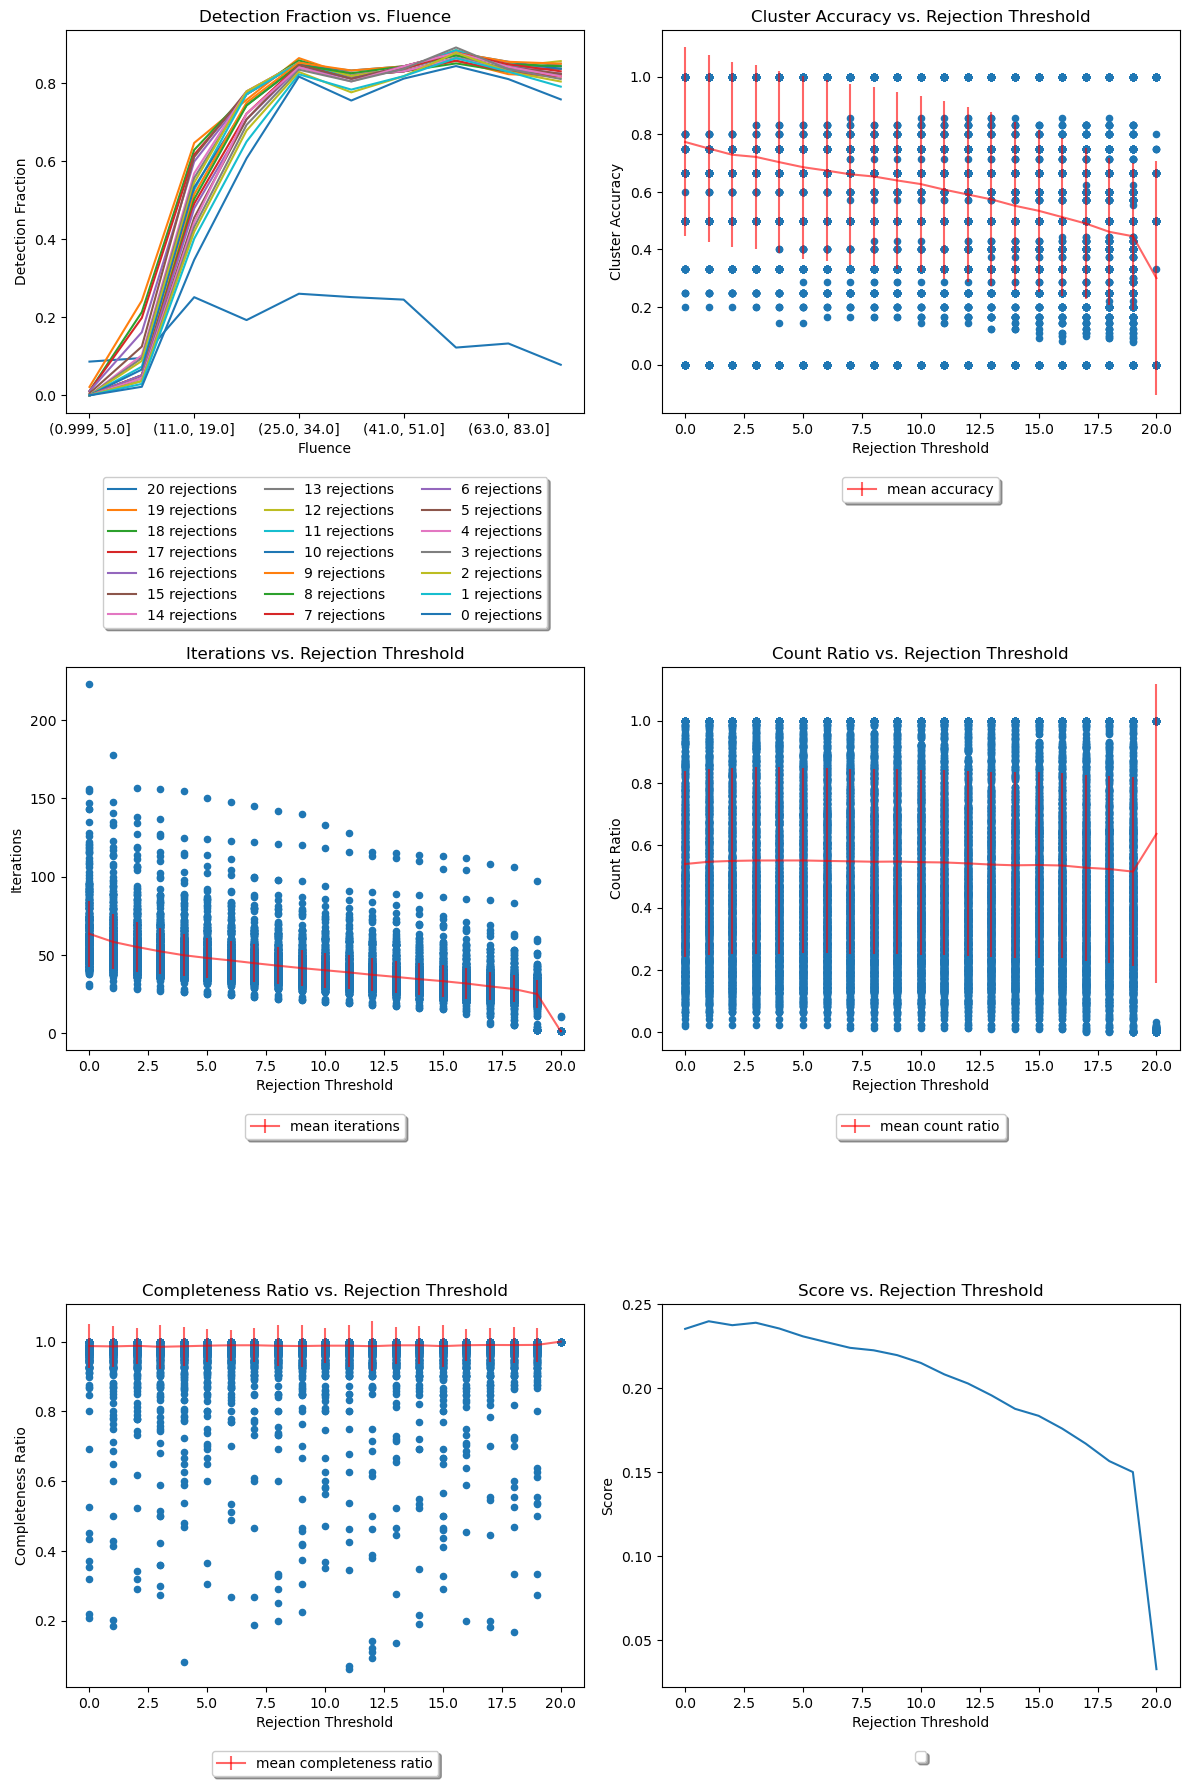

In [25]:
figsize = (12,18)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=figsize)

rtvsa = pd.DataFrame()


for rej_threshold in df["Rejection"].unique():
    df_layer = df[df["Rejection"] == rej_threshold]
    df_layer = df_layer.set_index("Fluence")
    #df_layer.index = df_layer.index.astype(float) 
    bins = pd.qcut(df_layer.index, q=10)

    mean_values = df_layer["Detected"].groupby(bins).mean()

    # if rej_threshold <= 40: mean_values.plot(ax=ax1, label=f"{int(rej_threshold)} rejections")
    mean_values.plot(ax=ax1, label=f"{int(rej_threshold)} rejections")

    tmp = df_layer.groupby("File").mean().reset_index()
    accuracies = tmp["Accuracy"]
    filenames = tmp["File"]
    iterations = tmp["Iteration"]
    true_positives = tmp["True Pos"]
    false_positives = tmp["False Pos"]
    new_rows = pd.DataFrame({"Rejection Threshold": np.full_like(accuracies, rej_threshold), 
                             "Iterations": iterations, 
                             "Accuracy": accuracies,
                             "True Positives": true_positives,
                             "False Positives": false_positives,
                             "File": filenames})
    rtvsa = pd.concat([rtvsa, new_rows], ignore_index=True)
    # lvsa.append({"Rejection Threshold": layers, "Mean Accuracy": df_layer.groupby("File").mean().reset_index()["Accuracy"].mean()*100}, ignore_index=True)


ax1.set_xlabel('Fluence')
ax1.set_ylabel('Detection Fraction')
ax1.set_title('Detection Fraction vs. Fluence')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

rtvsa.plot(kind="scatter", x="Rejection Threshold", y="Accuracy", ax=ax2)
# for file_name, group in lvsa.groupby('File'):
#     ax2.plot(group['Rejection Threshold'], group['Accuracy'], label=file_name, marker='o')
rtvsa_means = rtvsa[["Rejection Threshold","Accuracy"]].groupby("Rejection Threshold").mean().reset_index()
rtvsa_means["std"] = rtvsa[["Rejection Threshold","Accuracy"]].groupby("Rejection Threshold").std().to_numpy()

ax2.errorbar(rtvsa_means["Rejection Threshold"], rtvsa_means["Accuracy"], yerr=rtvsa_means["std"], label="mean accuracy", c="red", alpha=0.6)
ax2.set_xlabel('Rejection Threshold')
ax2.set_ylabel('Cluster Accuracy')
ax2.set_title("Cluster Accuracy vs. Rejection Threshold")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

rtvsa.plot(kind="scatter", x="Rejection Threshold", y="Iterations", ax=ax3)
rtvsa_means = rtvsa[["Rejection Threshold","Iterations"]].groupby("Rejection Threshold").mean().reset_index()
rtvsa_means["std"] = rtvsa[["Rejection Threshold","Iterations"]].groupby("Rejection Threshold").std().to_numpy()

ax3.errorbar(rtvsa_means["Rejection Threshold"], rtvsa_means["Iterations"], yerr=rtvsa_means["std"], label="mean iterations", c="red", alpha=0.6)
ax3.set_xlabel('Rejection Threshold')
ax3.set_ylabel('Iterations')
ax3.set_title("Iterations vs. Rejection Threshold")
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

filtered_groups = groups[groups["Detects"]][["Rejection","File","Counts","Detected Group Fluence","Original Group Fluence"]]
filtered_groups["Count Ratio"] = filtered_groups["Detected Group Fluence"] / filtered_groups["Counts"]
filtered_groups["Completeness Ratio"] = filtered_groups["Detected Group Fluence"] / filtered_groups["Original Group Fluence"]

filtered_groups.plot(kind="scatter", x="Rejection", y="Count Ratio", ax=ax4)
fg_means = filtered_groups[["Rejection","Count Ratio"]].groupby("Rejection").mean().reset_index()
fg_means["std"] = filtered_groups[["Rejection","Count Ratio"]].groupby("Rejection").std().to_numpy()

ax4.errorbar(fg_means["Rejection"], fg_means["Count Ratio"], yerr=fg_means["std"], label="mean count ratio", c="red", alpha=0.6)
ax4.set_xlabel('Rejection Threshold')
ax4.set_ylabel('Count Ratio')
ax4.set_title("Count Ratio vs. Rejection Threshold")
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

filtered_groups.plot(kind="scatter", x="Rejection", y="Completeness Ratio", ax=ax5)
fg_means = filtered_groups[["Rejection","Completeness Ratio"]].groupby("Rejection").mean().reset_index()
fg_means["std"] = filtered_groups[["Rejection","Completeness Ratio"]].groupby("Rejection").std().to_numpy()

ax5.errorbar(fg_means["Rejection"], fg_means["Completeness Ratio"], yerr=fg_means["std"], label="mean completeness ratio", c="red", alpha=0.6)
ax5.set_xlabel('Rejection Threshold')
ax5.set_ylabel('Completeness Ratio')
ax5.set_title("Completeness Ratio vs. Rejection Threshold")
ax5.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

scores = df[["Rejection","Detected"]].groupby("Rejection").mean()["Detected"] *\
 rtvsa[["Rejection Threshold","Accuracy"]].groupby("Rejection Threshold").mean()["Accuracy"] *\
 filtered_groups[["Rejection", "Count Ratio"]].groupby("Rejection").mean()["Count Ratio"] *\
 filtered_groups[["Rejection", "Completeness Ratio"]].groupby("Rejection").mean()["Completeness Ratio"]
scores.plot(kind='line', ax=ax6)

ax6.set_xlabel('Rejection Threshold')
ax6.set_ylabel('Score')
ax6.set_title("Score vs. Rejection Threshold")
ax6.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.tight_layout()
plt.show()


In [ ]:
total_false_positives = df[df["Rejection"] == 10].groupby("File").first()["False Pos"].sum()
false_positives_rate = total_false_positives/len(df["File"].unique())
print("Registered {} false positives ({:.2f} false positives per observation)".format(total_false_positives, false_positives_rate))

Registered 1179.0 false positives (1.19 false positives per observation)


In [26]:
index = int(input("Explore data from least accurate (index=0) to most accurate (index=-1). Index:"))

plotting


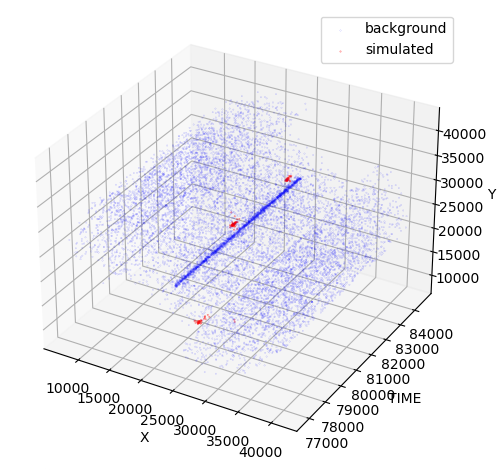

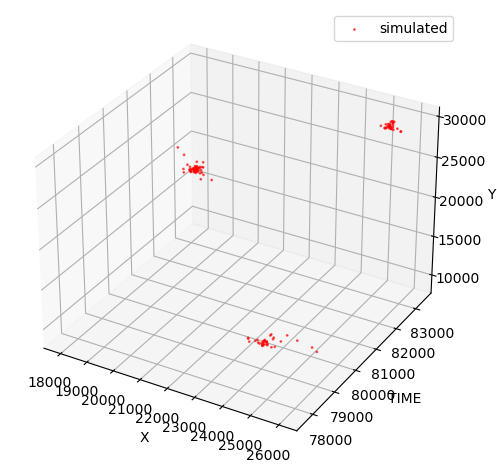

In [27]:
filename, layers = df[df["Rejection"] == 10].groupby("File").first()[["True Pos", "False Pos","Accuracy", "Iteration"]]\
    .sort_values(by="Accuracy").reset_index().iloc[index][["File", "Iteration"]]
layers = int(layers)
header = fits.open(filename)[0].header
dataset = MPTDDataset(filename, keys, filters, withsim)
print("plotting")
plot_data(dataset.data.x.cpu(), (0.01,0.1), dataset.data.y.cpu().bool(),keys)
plot_data(dataset.data.x.cpu(), (0.0,1), dataset.data.y.cpu().bool(),keys)

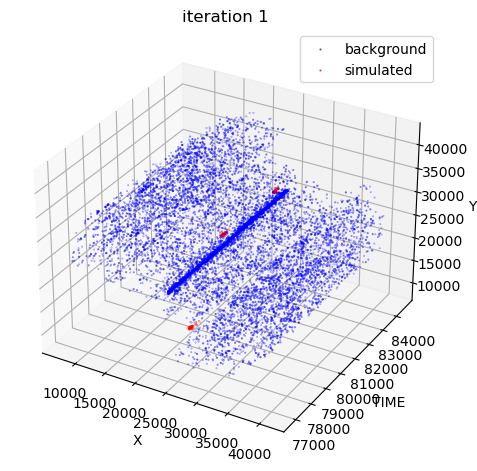

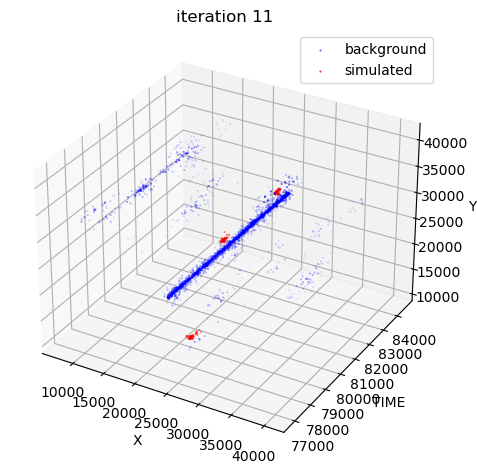

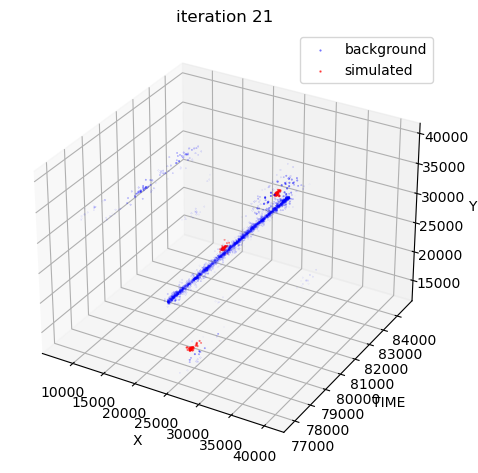

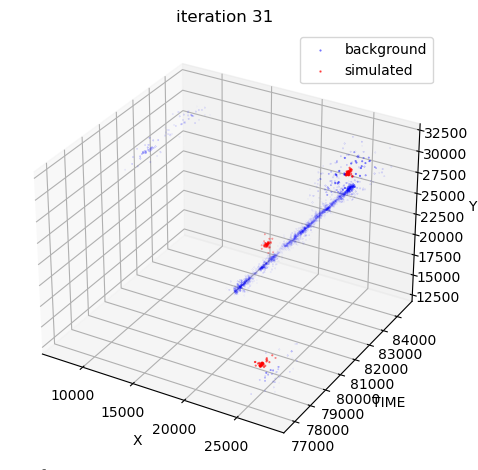

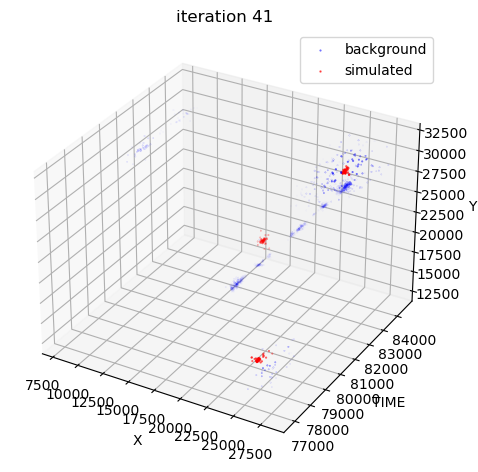

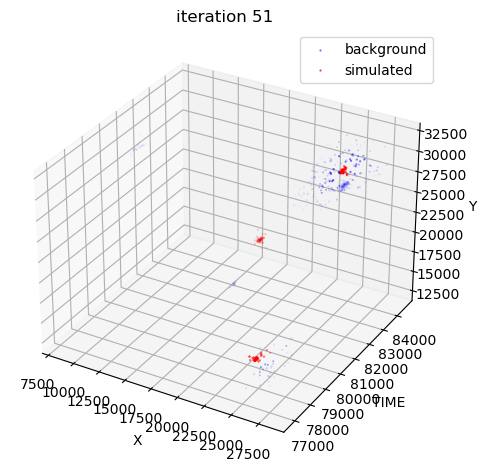

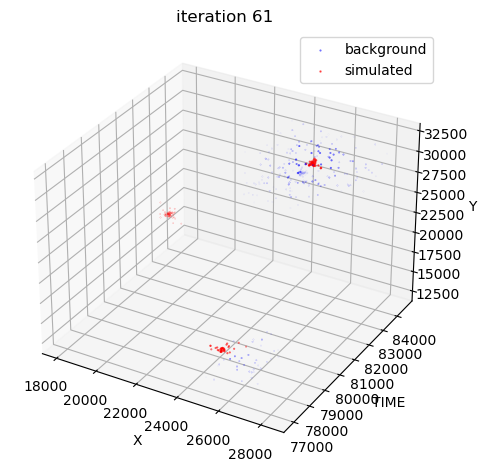

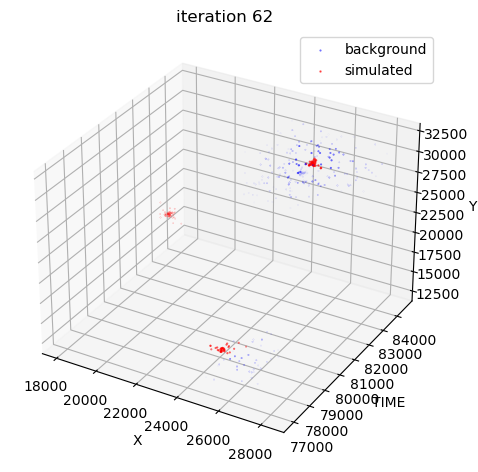

tensor([1.4477e-03, 1.9642e-02, 2.1717e-02,  ..., 6.8616e-07, 3.2701e-08,
        2.1934e-07])

In [28]:
transformer = ttr.KNNGraph(k=k, force_undirected=True)
model = SimpleMessage()
elaborator = MPTDElaborator(dataset,transformer,keys,model)

# elaborator.forward_plot(iterations=layers, plot_every=5, max_threshold=max_threshold)
# eps = elaborator.distances().median().item()/2
# eps = torch.quantile(elaborator.distances(), quantile).item()
eps = elaborator.distances().max().item()
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusterer = MPTDClusterer(algorithm=dbscan, max_threshold=max_threshold)
scorer = MPTDScorer(elaborator)
if save_every is None:
    save_every = np.inf

scorer.elaborator.forward_plot(iterations=layers, plot_every=10, plot_after=1, max_threshold=max_threshold)

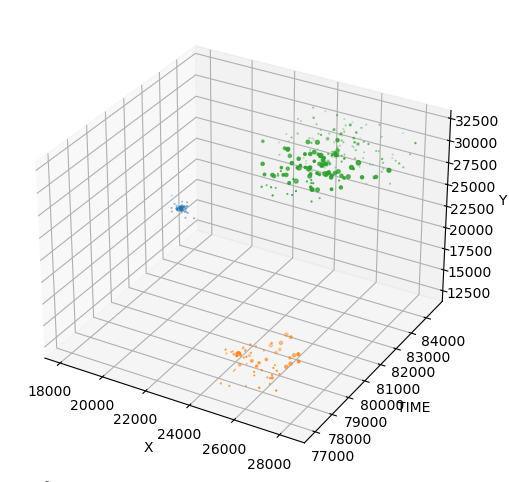

In [29]:
max_time_interval = 10_000
labels = clusterer.cluster(elaborator)
for group in np.unique(labels):
    if group < 0:
        continue
    mask = labels == group
    group_times = elaborator.dataset.data.pos[mask, 2].cpu()
    time_interval = group_times.max() - group_times.min()
    if time_interval > max_time_interval:
        labels[mask] = -1
mask = clusterer.mask(elaborator).cpu()
masked_data = clusterer.mask_data(elaborator).cpu()
plot_clusters(masked_data.pos, elaborator.sizes().cpu()[mask]*10, labels[mask].squeeze(), keys, figsize=(6,6))

In [ ]:
filename = osp.join("test.onD", "Icaro", "raw", "0690751601", "pps", "P0690751601M2S002MIEVLF0000.FTZ")
res, groups = auto_single_file_analysis([filename], keys, k, rej_thresholds, quantile, max_threshold, filters, min_samples, withsim, save_every, max_time_interval)

C:\Users\samuc\AppData\Local\Temp\ipykernel_7276\1051090628.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return self.num_true_positives()/len(np.unique(self.labels[self.labels>=0]))


In [ ]:
groups[groups["Rejection"]==10]["Detects"].mean()

0.8888888888888888

In [ ]:
res[res["Rejection"]==10]["Detected"].mean()

0.53333336